In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from playsound import playsound as play

%matplotlib inline

In [2]:
# This is the algorithm for computing DTFT of given signal
# The parameters for this Algorithm is a signal of shape (2, N) or  (N, )
# it has some default parameters like lower limit, higher limit and Number of points for omega axis

def dtft(signal, low_lim=-1*np.pi, high_lim=np.pi, N=100, endpoints=False):
    w = np.linspace(low_lim, high_lim, N, endpoint=endpoints)                  #Array of omega values
    e_jw = np.exp(w*1j)                                                    #computes e^{jw}
    
    # Creates a dictnationry to store dtft, Magnitude, Phase and omega
    dtft = dict()        
    # Creates a empty array for dtft
    dtft['complex'] = np.zeros(N, dtype=complex) 
    # Assiging omega values 
    dtft['omega'] = w
    
    # The following conditional statements are for checking whether the input(signal) is been provided with 
    # time stamps
    if signal.ndim == 2:
        for i in range(signal.shape[1]):
            dtft['complex'] += signal[0, i]*np.power(e_jw, -1*signal[1, i])
    else:
        for i in range(signal.shape[0]):
            dtft['complex'] += signal[i]*np.power(e_jw, -1*i)

    # Rounds-off the result upto 4 decimal places
    dtft['complex'] = np.round(dtft['complex'], decimals=4)
    # Finds the magnitude of the dtft computed above.
    dtft['magnitude'] = np.absolute(dtft['complex'])
    # Finds the phase of dtft in radians which lies in the range[-pi, pi]
    dtft['phase'] = np.angle(dtft['complex'], deg=0)
    return dtft

# This function is used for plotting Real part, Imaginary part, Magnitude and Phase for a given DTFT

def dtft_plotter(dtft, title=None, complex_part=True):
    plt.rcParams['figure.figsize'] = [10, 8]
    
    if complex_part:
        fig, ax = plt.subplots(2,2)

        if title != None:
            fig.suptitle(title, fontweight="bold")

        ax[0, 0].title.set_text('Real Part')
        ax[0, 0].stem(dtft['omega'], np.real(dtft['complex']))
        ax[0, 0].set(ylabel='$Re\{X(e^{j \omega})\}$')

        ax[0, 1].title.set_text('Imaginary Part')
        ax[0, 1].stem(dtft['omega'], np.imag(dtft['complex']), 'tab:red')
        ax[0, 1].yaxis.tick_right()
        ax[0, 1].set(ylabel='$Im\{X(e^{j \omega})\}$')

        ax[1, 0].title.set_text('Magnitude')
        ax[1, 0].stem(dtft['omega'], dtft['magnitude'], 'tab:orange')
        ax[1, 0].set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

        ax[1, 1].title.set_text('Phase')
        ax[1, 1].stem(dtft['omega'], dtft['phase'], 'tab:green')
        ax[1, 1].yaxis.tick_right()        
        ax[1, 1].set(xlabel='$\omega$', ylabel='$\phi$(in radians)')
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.stem(dtft['omega'],dtft['magnitude'])
        ax1.set(xlabel='$\omega$', ylabel='$X(e^{j \omega})$')
        ax1.title.set_text('Magnitude')

        ax2.stem(dtft['omega'],dtft['phase'], 'tab:green')
        ax2.plot(xlabel = 'n', ylabel=r'$\phi$(in radians)')
        ax2.title.set_text('Phase')
        
def convolve(x, h, n_x=None, plot=True, N=100):
    n  =  x.shape[0]
    m = h.shape[0]
    h = np.flip(h)
    pads = np.zeros(m-1)
    X =  np.hstack((pads, x, pads))
    y = np.array([np.dot(X[i:i+m], h) for i in range(n+m-1)])
    nY = y.shape[0]
    if plot:
        px = np.hstack((x, np.zeros(nY-n)))
        if n%2 ==1:
            N = np.hstack((n_x, np.array([(n-1)/2+i for i in range(nY-n)])))
        else:
            N = np.hstack((n_x, np.array([n/2+i for i in range(nY-n)])))
        plt.rcParams['figure.figsize'] = [10, 8]
        plt.rc('axes', labelsize=12)

        fig, (ax1,ax2) = plt.subplots(2, 1)
        ax1.stem(N, px)
        ax1.set(xlabel='n', ylabel='x[n]')
        ax2.stem(N, y)
        ax2.set(xlabel='n', ylabel='y[n]')
    
    return y

#Function which convolves the data from a wave file and creates a new wave file with
#data resulting from the convolution of original signals data and given impulse response
def audio_convolve(i, h, normalisation, o, time_len=None):
    #Reading and extracting data from the original signal  
    x, t, nframes, fr = wavfile_to_nparray(i, time_len=time_len, normalise=normalisation)    
    #Creating the newfile
    y_file = o
    y_filep = wave.open(y_file, 'wb')
    #Setting the wave file parameters
    y_filep.setnchannels(1)
    y_filep.setsampwidth(1)
    y_filep.setframerate(fr)
    #Finding the convolution data 
    y = convolve(x, h, plot=False)
    #Normalising the data 
    if normalisation:
        y = np.clip(y, -1, 1)
        y = (y+1)*(2**7)
    else:
        print(np.max(y), np.min(y))
        if np.min(y) < 0:
            y = y + np.min(y)
        #y = np.clip(y, 0, 255)
    #Converting the byte code to nparray
    y = y.astype(np.int8)
    y = y.tobytes()
    y_filep.writeframesraw(y)#Writing the new framesdata
    y_filep.close()#Closing the wave file

    return y_file
#This below function will take a file as .wav audio file as input and that verbose default parameter which will
#helpful for printing Specifications of audio file such as #frames, framerate, duration, etc.
#Output of this function will return audio signal array, time duration and Number of frames

def wavfile_to_nparray(FILE, verbose=0, time_len=None, normalise=False):
    audio_file = wave.open(FILE, 'rb')             #Opening the .wav file
    params = audio_file.getparams()                #Getting parameters of the audio file
    fr = params[2]
    if time_len != None:
        nframes = int(time_len*fr)
    else:
        nframes = params[3]
    audio_frame = audio_file.readframes(nframes)        #Reading all frames of the audio file 
    audio = np.zeros(nframes)                    #Creating an empty array for storing the values
    
    # Since the frames are3 being stores as bytes format each value will be a size of 1Byte(*bits)
    # Thus we get values ranging from 0 to 255
    # To avoid large values of dtft magnitude so we are normalizing signal from -1 to 1 
    # the audio signal to have better representation in time domain
    
    for i in range(len(audio_frame)):              
        audio[i] = audio_frame[i]                  #Storing the byte value in int array

    duration = nframes/fr                 #Time duration of the signal
    #Normalising the wave amplitude
    if normalise:
        audio = audio/2**7 - 1
    #Printing all the parameters of the wave
    if verbose:
        print('Channels=',params[0], ', SampleWidth=', params[1],'\bbytes' 
              ,', Framerate=', fr, '\bHz', ', Frames=', nframes, '\nDuration:', time_len if time_len else 
              duration, '\bs\n')
    return audio, duration, nframes, fr

#This below function will Plot the Time signal. Computes DTFT and also plots Magnitude and phase

def analyise_wav_file(file, normalise, time_len=None, verbose=0):
    #Reading the wave file, and converting to array
    audio, t, frames, _ = wavfile_to_nparray(file, verbose=verbose, time_len=time_len, normalise=normalise)
    time = np.linspace(0, t, frames)          #Time scale
    
    dtft_audio = dtft(audio, N=100)           #Finding the DTFT of the wave file
    
    plt.rcParams['figure.figsize'] = [20, 4]  #Setting the plotting area
    plt.rc('axes', labelsize=12)              #Setting the labels size
    
    plt.figure()                                            #Plotting Time signal
    plt.title(file, fontsize='large', fontweight='bold')
    plt.plot(time, audio, color='green')
    plt.xlabel('n')
    plt.ylabel('Amplitude')

#                                                             #Plotting Magnitude and Phase
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.suptitle("DTFT of "+file)
    ax1.title.set_text('Magnitude')
    ax1.stem(dtft_audio['omega'], dtft_audio['magnitude'])
    ax1.set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

    ax2.title.set_text('Phase')
    ax2.set(xlabel='$\omega$', ylabel='$\phi$')
    ax2.stem(dtft_audio['omega'], dtft_audio['phase'], 'tab:red')
#     dtft_plotter(dtft_audio)

Please enter N:- 1
Please enter M:- 5
Please enter a0:- 1
Please enter b0:- 0
Please enter b1:- 0
Please enter b2:- 2
Please enter b3:- 3
Please enter b4:- 4


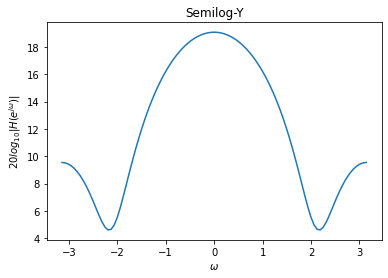

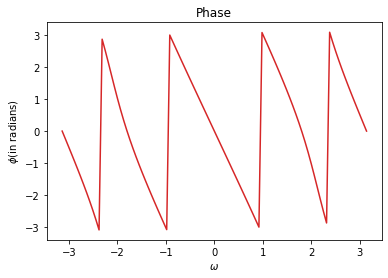

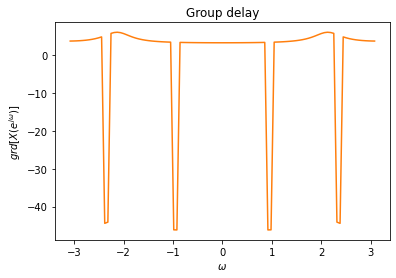

In [3]:
# sigma(ak*y[n-k]) = sigma(bk*x[n-k])
# A = [a0, a1, a2, a3, ..., ak]
# B = [b0, b1, b2, b3, ..., bk]

def q1(A, B, w_low_lim=-1*np.pi, w_high_lim=np.pi, N=100):
    w = np.linspace(w_low_lim, w_high_lim, N)
    e_jw = np.exp(w*1j)
    
    asum = np.zeros(N, dtype=complex)
    bsum = np.zeros(N, dtype=complex)
    
    if A.ndim == 2:
        for i in range(A.shape[1]):
            print(A[0, i].shape, np.power(e_jw, -1*A[1, i]))
            asum += A[0, i]*np.power(e_jw, -1*A[1, i])
    else:
        for i in range(A.shape[0]):
            asum += A[i]*np.power(e_jw, -1*i)
            
    if B.ndim == 2:
        for i in range(B.shape[1]):
            bsum += B[0, i]*np.power(e_jw, -1*B[1, i])
    else:
        for i in range(B.shape[0]):
            bsum += B[i]*np.power(e_jw, -1*i)
            
    H_ejw = bsum/asum
    q1 = dict()
    q1['H_ejw'] = H_ejw
    q1['20log10'] = 20*np.log10(np.absolute(H_ejw))
    q1['phase'] = np.angle(H_ejw)
    q1['grd'] = group_delay(q1['phase'], w)
    q1['omega'] = w
    return q1

def group_delay(phi, w):
    grd = []
    for i in range(1, len(phi)-1):
        grd.append((phi[i+1] - phi[i-1])/(w[i-1] - w[i+1]))
    grd = np.array(grd)
    return grd

# This function is used for plotting Real part, Imaginary part, Magnitude and Phase for a given LCCDE H(e^jw)

def q1_plotter(q1, title=None, complex_part=True):

    plt.figure()
    plt.title('Semilog-Y')
    plt.plot(q1['omega'], q1['20log10'])
    plt.ylabel('$20log_{10}{|H(e^{j\omega})|}$')
    plt.xlabel('$\omega$')
    
    plt.figure()
    plt.title('Phase')
    plt.plot(q1['omega'], q1['phase'], 'tab:red')
    plt.ylabel('$\phi$(in radians)')
    plt.xlabel('$\omega$')
    
    plt.figure()
    plt.title('Group delay')
    plt.plot(q1['omega'][1:-1], q1['grd'], 'tab:orange')
    plt.xlabel('$\omega$')
    plt.ylabel('$grd[X(e^{j \omega})]$')

#Question 1
N = int(input("Please enter N:- "))
M = int(input("Please enter M:- "))
A = []
B = []
for i in range(N):
    A.append(float(input('Please enter a'+str(i)+':- ')))
for i in range(M):
    B.append(float(input('Please enter b'+str(i)+':- ')))

A = np.array(A)
B = np.array(B)
H = q1(A, B)

q1_plotter(H)

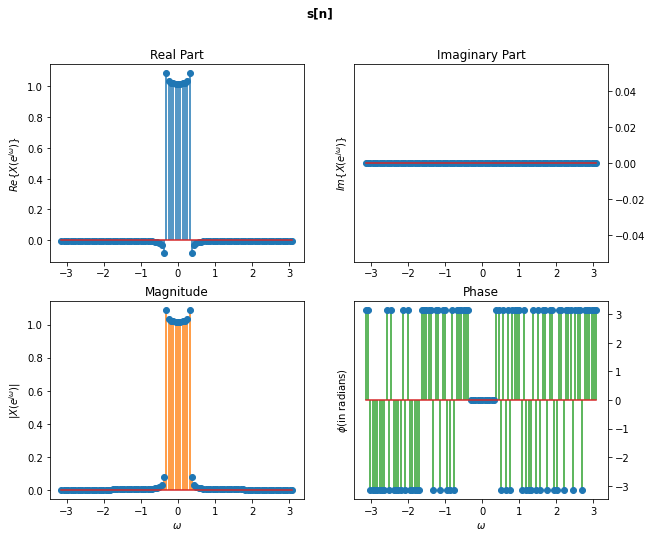

In [4]:
#Question 2

#Observe the DTFT of s[n]

N = 100
n = np.linspace(-N, N, 2*N+1)
w_0 = 8*np.pi/27

w_b = np.pi/9

s_n = w_b*np.sinc(w_b*n/np.pi)/np.pi

S_ejw = dtft(s_n)
dtft_plotter(S_ejw, title='s[n]')


x_n = s_n*(np.cos(w_0*n)+np.cos(2*w_0*n)+np.cos(3*w_0*n))

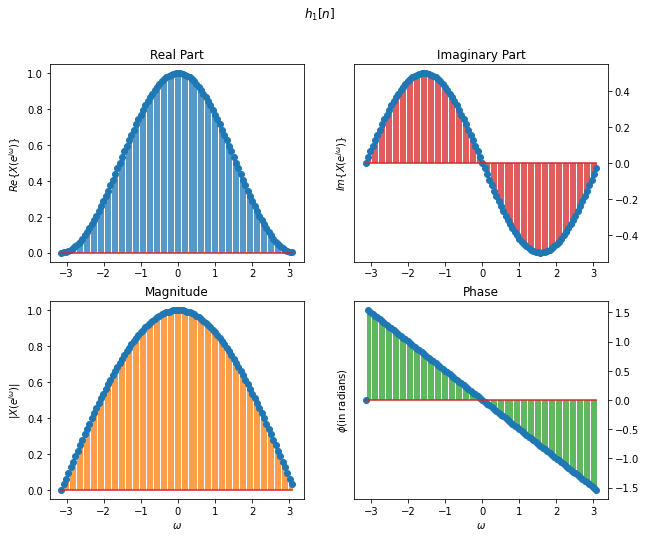

In [5]:
#h1[n]
h1 = np.array([0.5, 0.5])

H_1 = dtft(h1)
dtft_plotter(H_1, title='$h_1[n]$')

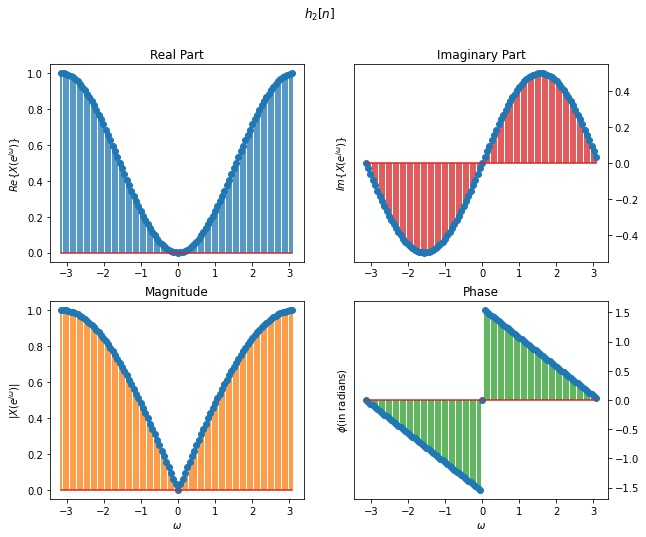

In [6]:
#h2[n]
h2 = np.array([0.5, -0.5])

H_2 = dtft(h2)
dtft_plotter(H_2, title='$h_2[n]$')

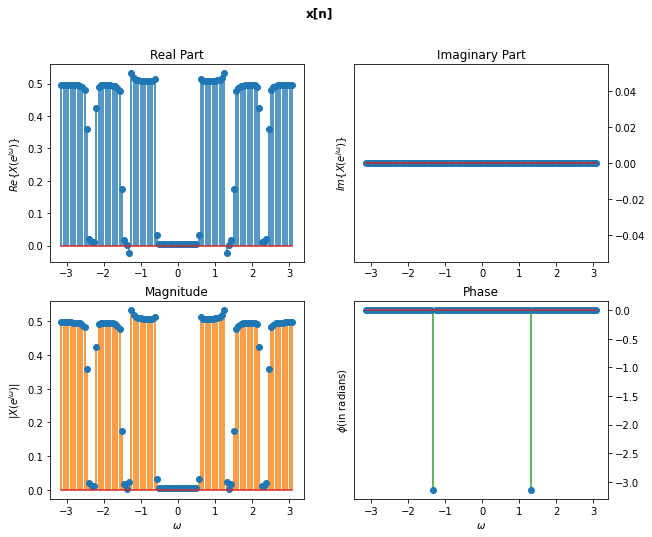

In [7]:
#DTFT plot of x[n]

X_ejw = dtft(x_n)
dtft_plotter(X_ejw, title='x[n]')

Since our Group delay is 0.5 approx, Which makes the envolope s[n]  to shift by 0.5 sample which is not possible so it shifts by one sample.


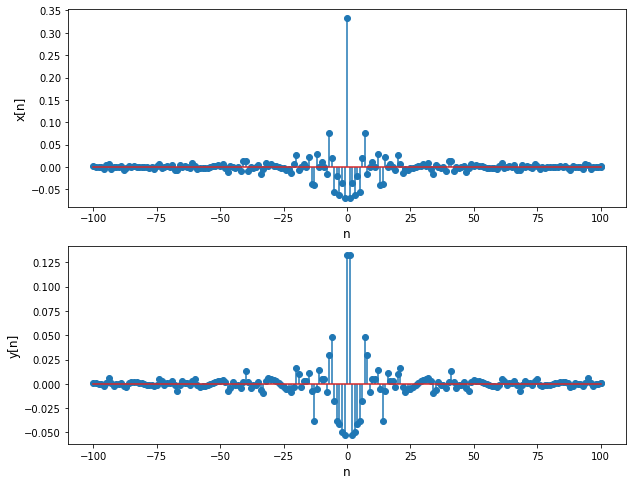

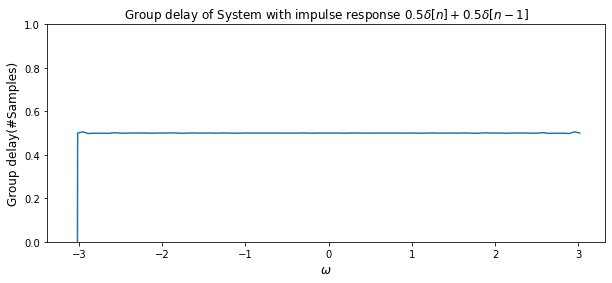

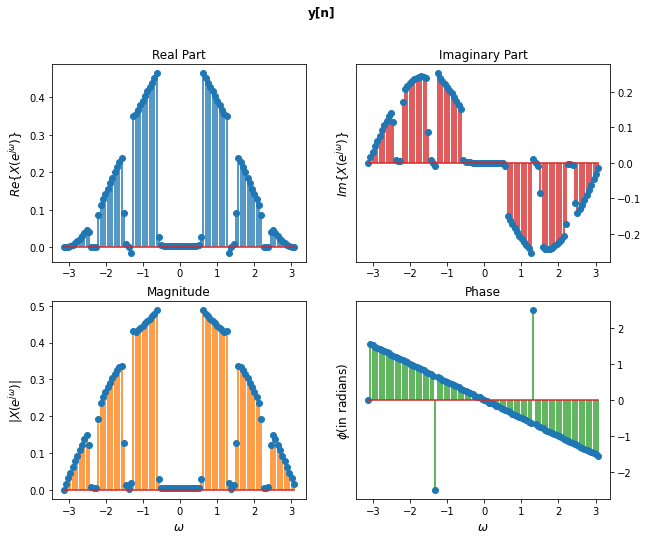

In [8]:
#applying H1[n]
y_1 = convolve(x_n, h1, n_x=n,plot=True)
H_1 = dtft(h1)


grd = group_delay(H_1['phase'], H_1['omega'])

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group delay of System with impulse response $0.5\delta[n]+0.5\delta[n-1]$')
plt.plot(H_1['omega'][1:-1], grd)
plt.xlabel('$\omega$')
plt.ylabel('Group delay(#Samples)')
plt.ylim(0, 1)

Y1_ejw  = dtft(y_1)
dtft_plotter(Y1_ejw, title='y[n]')
print('Since our Group delay is 0.5 approx, Which makes the envolope s[n]'
      ,' to shift by 0.5 sample which is not possible so it shifts by one sample.')

Since our Group delay is 0.5 approx, Which makes the envolope s[n]  to shift by 0.5 sample which is not possible so it shifts by one sample,  And also since here phase out by 90 deg so we can see invertion of shifted samples.


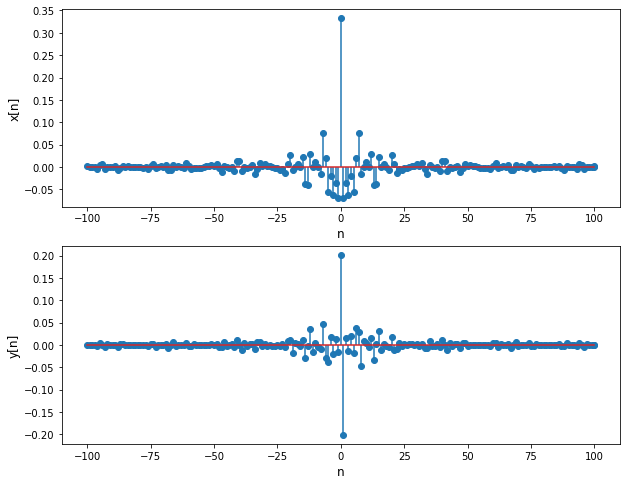

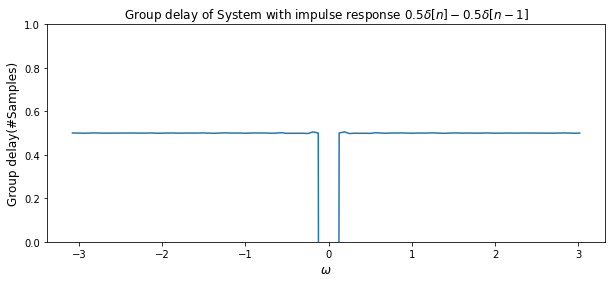

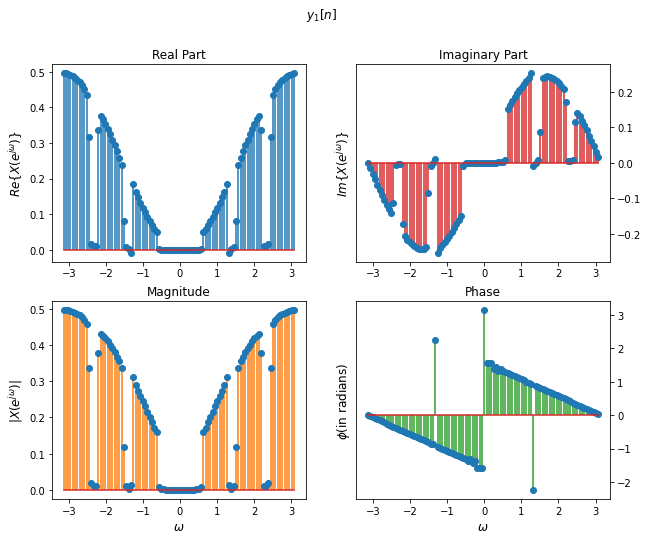

In [9]:
y_2 = convolve(x_n, h2, n_x=n, plot=True)
H_2 = dtft(h2)


grd = group_delay(H_2['phase'], H_2['omega'])

plt.rcParams['figure.figsize'] = [10, 4]
plt.figure()
plt.title('Group delay of System with impulse response $0.5\delta[n]-0.5\delta[n-1]$')
plt.plot(H_2['omega'][1:-1], grd)
plt.xlabel('$\omega$')
plt.ylabel('Group delay(#Samples)')
plt.ylim(0, 1)

Y2_ejw  = dtft(y_2)
dtft_plotter(Y2_ejw, title='$y_1[n]$')
print('Since our Group delay is 0.5 approx, Which makes the envolope s[n]'
      ,' to shift by 0.5 sample which is not possible so it shifts by one sample,'
      ,' And also since here phase out by 90 deg so we can see invertion of shifted samples.')

255.0 0.0
Here clearly the filter has linear phase and we can observe that signal waveform is retained.


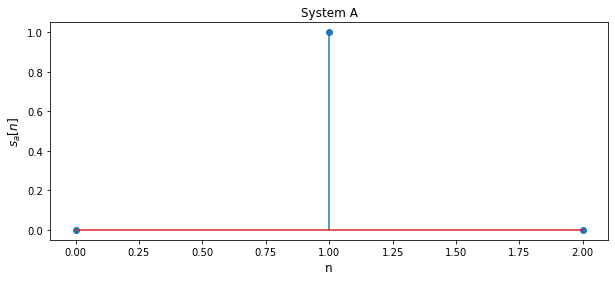

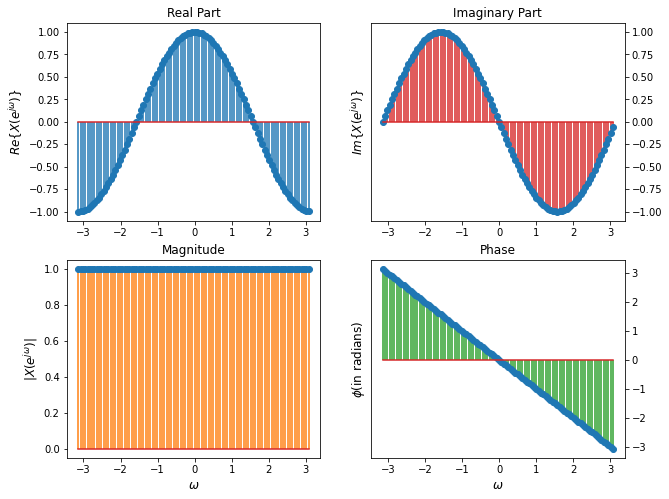

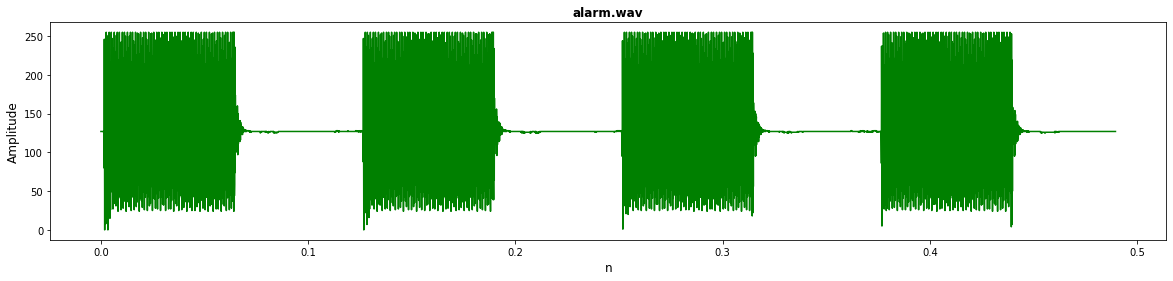

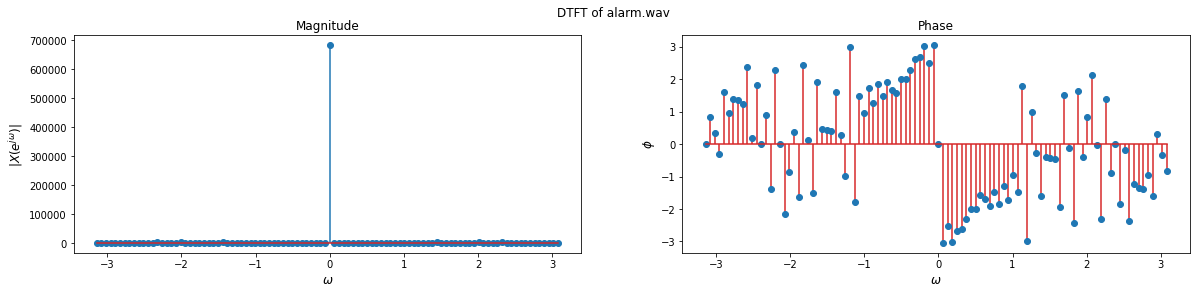

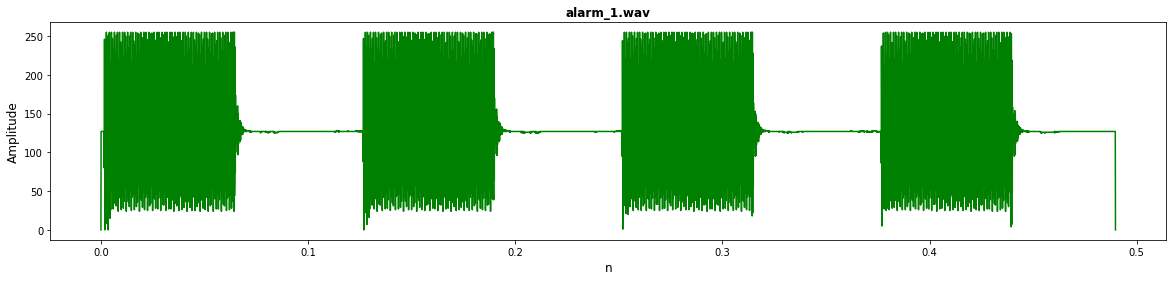

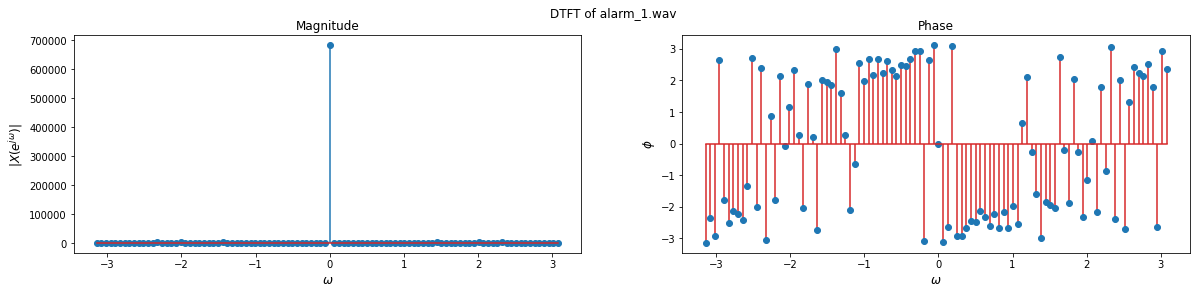

In [10]:
#Question 3

#Linear Phase system

#System A
s_a = np.array([0, 1, 0])
plt.rcParams['figure.figsize'] = [10, 4]
plt.title('System A')
plt.stem(s_a)
plt.ylabel('$s_a[n]$')
plt.xlabel('n')
S_A=dtft(s_a)
dtft_plotter(S_A)

#Operating on Cry File
file = 'alarm.wav'
#Getting the convolved wave file
op = audio_convolve(file, s_a, normalisation=False, o=file[:-4] + "_1.wav")
#Original wave file
play(file)#Playing the original wave file
analyise_wav_file(file, normalise=False)#Analysing the wavefile
#Operated wave file
play(op)#Playing the convolved wave file
analyise_wav_file(op, normalise=False)#Analysing the wavefile

print('Here clearly the filter has linear phase and we can observe that signal waveform is retained.')

316.0 -293.5
Here clearly the filter has linear phase and we can observe that signal waveform is not retained,  rather it is distorted.


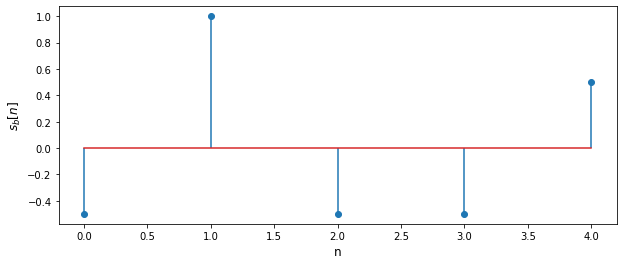

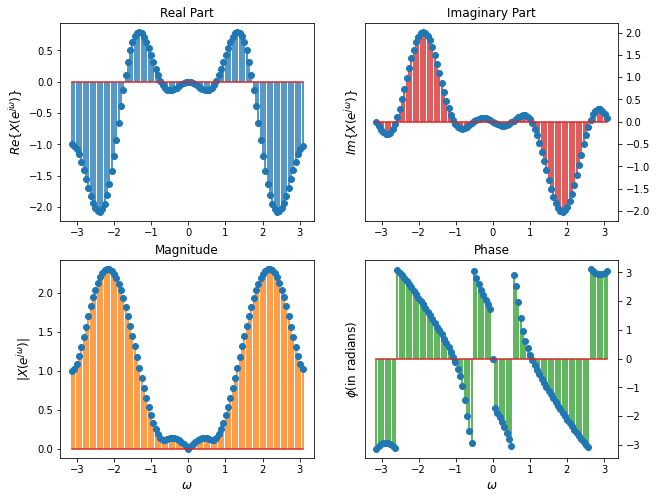

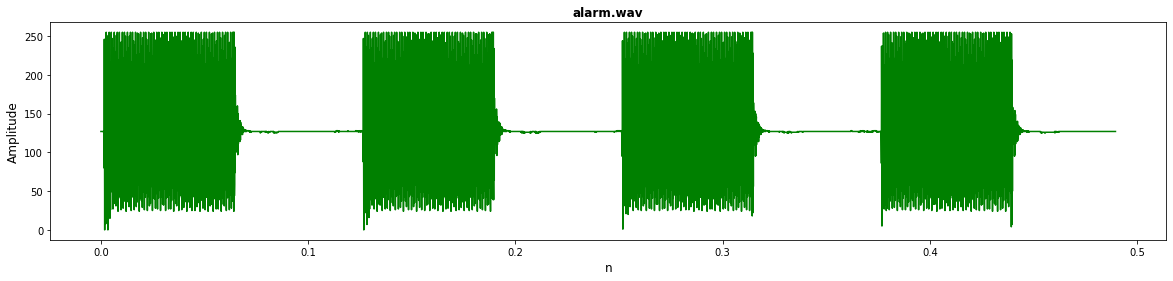

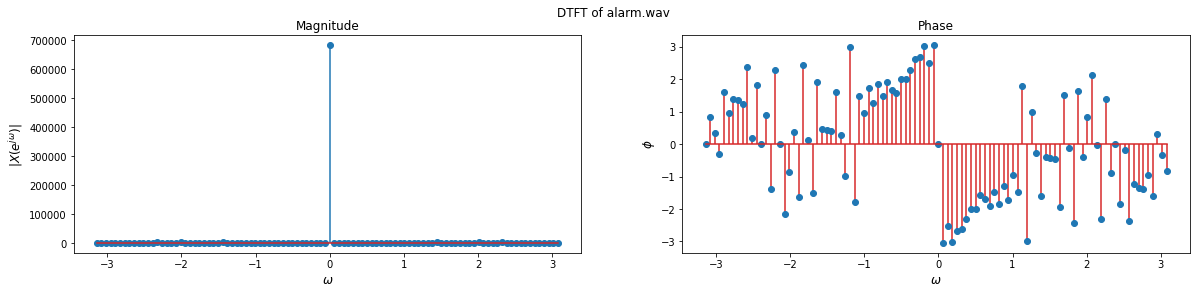

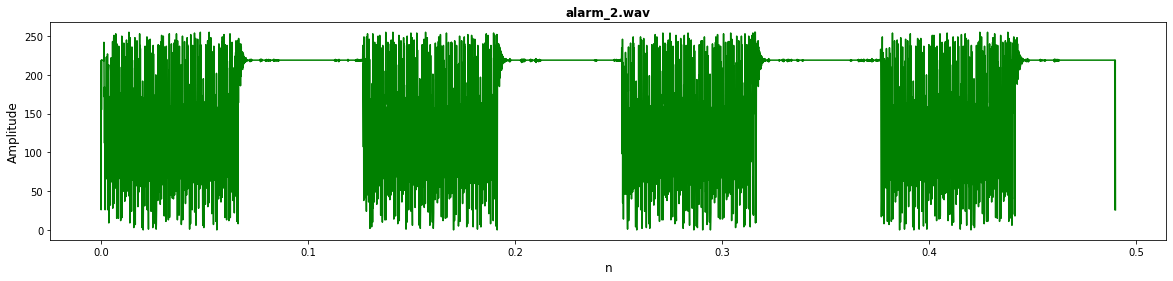

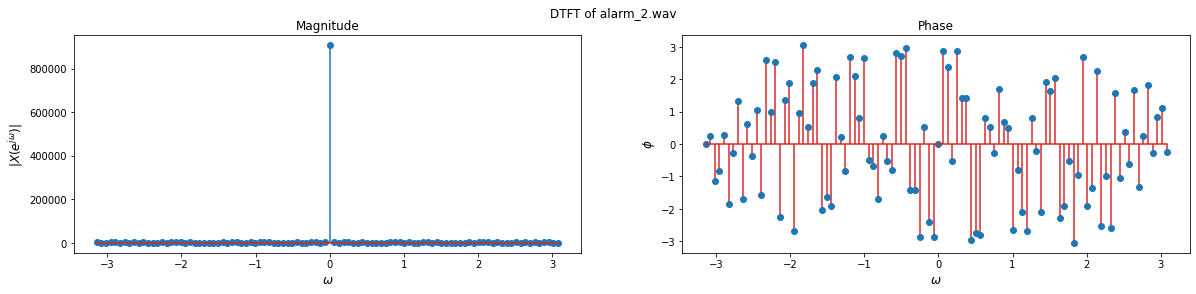

In [11]:
#Non-Linear Phase system

#System B

s_b = np.array([-0.5, 1, -0.5, -0.5, 0.5])
plt.rcParams['figure.figsize'] = [10, 4]
plt.stem(s_b)
plt.ylabel('$s_b[n]$')
plt.xlabel('n')
S_B=dtft(s_b)
dtft_plotter(S_B)

#Operating on Cry File
file = 'alarm.wav'
#Getting the convolved wave file
op = audio_convolve(file, s_b, normalisation=False, o=file[:-4] + "_2.wav")
#Original wave file
play(file)#Playing the original wave file
analyise_wav_file(file, normalise=False)#Analysing the wavefile
#Operated wave file
play(op)#Playing the convolved wave file
analyise_wav_file(op, normalise=False)#Analysing the wavefile

print('Here clearly the filter has linear phase and we can observe that signal waveform is not retained,', 
      ' rather it is distorted.')